# 1. Install package

In [1]:
!pip install pypandoc
!pip install underthesea
!pip install sentence_transformers
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
!pip install seaborn
!pip install tensorflow
# !pip uninstall -y keras
!pip install keras
!pip install itertools
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.1 MB/s eta 0:00:00
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-2ur95ihr
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-2ur95ihr
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit e5b1f0710cb1ea5ebbc73d30abe8d45a07cbb399
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess_kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11722 sha256=a2cb9bd75a2ebe40fdb1db3a3f1f0e1db306ec392b49d32bc9f17dd9b4e90c40
  Stored in directory: /tmp/pip-ephem-wheel-cache-fcc075ub/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a

In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=414ff537b3a056408117f2757c41e288d00f48ec493bfdde6492fb77da51c14f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


# 2. Import package

In [3]:
import pickle
import torch
from GPUtil import showUtilization as gpu_usage
# torch.cuda.empty_cache()

In [4]:
from sklearn.calibration import CalibratedClassifierCV
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier
import cudf, cuml
import asyncio
import base64
import decimal
import json
from datetime import datetime, date
import os
from pathlib import Path

import flask
# import pymysql
import requests
from flask import Flask, render_template, request
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
# from sklearn.svm import LinearSVC, SVC
from cuml.svm import SVC, LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from sklearn import tree
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc,  confusion_matrix, recall_score, precision_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, auc
import openpyxl
import pandas as pd
import numpy as np
import preprocess_kgptalkie as ps
import re
import glob
import os
from underthesea import sentiment, pos_tag, word_tokenize
from flask import g
from sklearn.pipeline import Pipeline
import underthesea
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from pandas.errors import ParserError
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os.path
import pypandoc

import seaborn as sns

import tensorflow as tf
import keras
from keras import layers
from itertools import cycle

from xgboost import XGBClassifier

2024-08-04 14:25:04.411056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 14:25:04.411196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 14:25:04.535060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3. Functions collect data from source

In [5]:
SIZE_DEMO = 20000

root = '/dataset/**/'
root2 = '/sentiment_transformer/other_dataset/'


def get_stopwords_list(stop_file_path):
    """load stop words """

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))


stopwords_path = "/kaggle/input/dataset2/vietnamese.txt"
stopwords = get_stopwords_list(stopwords_path)


def load_transformer_model():
    print(os.path.isdir("model"))
    if not os.path.isdir("model"):
        model = SentenceTransformer('keepitreal/vietnamese-sbert')
        model.save("model")
        return model
    return SentenceTransformer('model')


def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    # x = str(x).lower()
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    # x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x


def load_data_train_to_excel(root):
    data_train = pd.DataFrame()
    all_files_train = glob.glob(root + "train/**/*.txt", recursive=True)
    for f in all_files_train:
        df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip')
        with open(f, mode='r', encoding="utf8") as f:
            df['Review'] = get_clean(f.read())
            df['Sentiment'] = ""
        data_train = pd.concat([data_train, df], ignore_index=True)
    data_train.to_csv('data_train.csv', index=False)


def remove_stop_words(corpus, stop_words):
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))

    return results


def load_data_test_to_excel(root):
    data_test = pd.DataFrame()
    sentiment_array = ["negative", "positive", "neutral"]
    all_files_test = []
    for i in [-1, 1, 2]:
        all_files_test = glob.glob(f'{root}test/{i}/*.txt', recursive=True)
        print(i)
        for f in all_files_test:
            df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE)
            with open(f, mode='r', encoding="utf8") as f:
                df['Review'] = get_clean(f.read())
                df['Sentiment'] = sentiment_array[(i + 1) if i == -1 else i]
            data_test = pd.concat([data_test, df], ignore_index=True)
            # print(data_test
    data_test.to_csv('data_test.csv', index=False)


def load_data_test_to_excel2(root):
    data_test = pd.DataFrame()
    sentiment_array = ["nv_tot", "nv_xau", "shop_tot", "shop_xau", "sp_tot", "sp_xau"]
    all_files_test = []
    for i in sentiment_array:
        all_files_test = glob.glob(f'{root}{i}/*.txt', recursive=True)
        print(i)
        for f in all_files_test:
            df = pd.read_csv(f, header=None, sep=' ', names=['Review', 'Sentiment'], on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE)
            with open(f, mode='r', encoding="utf8") as f:
                df['Review'] = get_clean(f.read())
                df['Sentiment'] = i
            data_test = pd.concat([data_test, df], ignore_index=True)
            # print(data_test
    data_test.to_csv('data_test2.csv', index=False)


def convert_docx_to_txt(root):
    sentiment_array = ["nv_tot", "nv_xau", "shop_tot", "shop_xau", "sp_tot", "sp_xau"]
    all_files_test = []
    for i in sentiment_array:
        all_files_test = glob.glob(f'{root}{i}/*.docx', recursive=True)
        for f in all_files_test:
            docxFilename = f'{root}{i}/{Path(f).stem}{Path(f).suffix}'
            output = pypandoc.convert_file(docxFilename, 'plain', outputfile=f'{root}{i}/{Path(f).stem}.txt')
            os.remove(f'{root}{i}/{Path(f).stem}{Path(f).suffix}')


# convert_docx_to_txt(root2)

# load_data_train_to_excel(root)
# load_data_test_to_excel(root)
# load_data_test_to_excel2(root2)


def get_clean_slang_misspell(x):
    df_misspell_pd = df_misspell.to_pandas()
    df_slang_word_pd = df_slang_word.to_pandas()
    df_slang_pd = df_slang.to_pandas()
    for idx, row in df_misspell_pd.iterrows():
        if row['wrong'] in x:
            x = x.replace(row['wrong'], row['right'])

    for idx, row in df_slang_word_pd.iterrows():
        if row['Slangs'] in x:
            x = x.replace(row['Slangs'], row['Values'])
    
    for idx, row in df_slang_pd.iterrows():
        if row['Slangs'] in x:
            x = x.replace(row['Slangs'], row['Values'])

    return x

# 4. Read Data

In [6]:
df = cudf.read_csv('/kaggle/input/dataset/data.csv')
df.drop_duplicates(subset='Review', keep="first", inplace=True)
df_slang = cudf.read_csv('/kaggle/input/dataset/sentences.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_slang_word = cudf.read_csv('/kaggle/input/dataset/words.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_misspell = cudf.read_csv('/kaggle/input/dataset/dataset.csv', skipinitialspace=True, usecols=['stt', 'wrong', 'right'])
df

,Sentiment,Review,label,num_character,num_of_word,num_sentences
0,nv_tot,Nhân viên luôn nhiệt tình và thân thiện với kh...,0,55,12,1
1,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,62,15,1
2,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0,65,15,1
3,nv_tot,Nhân viên rất nhiệt tình và thân thiện với mọi...,0,62,14,1
4,nv_tot,Dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...,0,70,17,1
...,...,...,...,...,...,...
1232,sp_xau,"""Dây đeo rất cứng và thô, đeo vào tay cảm thấy...",5,65,17,1
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi...",5,122,32,3
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết ""\n",5,31,9,1
1235,sp_xau,"""Chưa lột sạch mụn hẳn ""\n",5,25,7,1


In [7]:
CLASS_NAMES = list(df["Sentiment"].to_pandas().unique())
CLASS_NAMES

['nv_tot', 'nv_xau', 'shop_tot', 'shop_xau', 'sp_tot', 'sp_xau']

# 5. Data preprocessing

In [8]:

df['Review'] = df['Review'].to_pandas().apply(get_clean)



df['Review'] = df['Review'].to_pandas().map(get_clean_slang_misspell)


/opt/conda/lib/python3.10/site-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


# 6. EDA

## 6.1 Distribution of Sentiment

In [9]:
df['Sentiment'].value_counts()

Sentiment
sp_tot      425
sp_xau      267
shop_tot    152
shop_xau    119
nv_xau      102
nv_tot       51
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7e78247db070>,
 [Text(0.4022868338109557, 1.0237994448828134, 'sp_tot'),
  Text(-1.0999956412997425, -0.0030966306800321096, 'sp_xau'),
  Text(-0.41665673061351954, -1.018035936907167, 'shop_tot'),
  Text(0.4022869057022213, -1.023799416634202, 'shop_xau'),
  Text(0.9235482297176578, -0.5975438623108605, 'nv_xau'),
  Text(1.088683085114632, -0.15738214697127265, 'nv_tot')],
 [Text(0.21942918207870307, 0.5584360608451708, '38.08'),
  Text(-0.5999976225271322, -0.001689071280017514, '23.92'),
  Text(-0.22726730760737426, -0.5552923292220909, '13.62'),
  Text(0.2194292212921207, -0.5584360454368373, '10.66'),
  Text(0.5037535798459951, -0.32593301580592393, '9.14'),
  Text(0.5938271373352537, -0.08584480743887597, '4.57')])

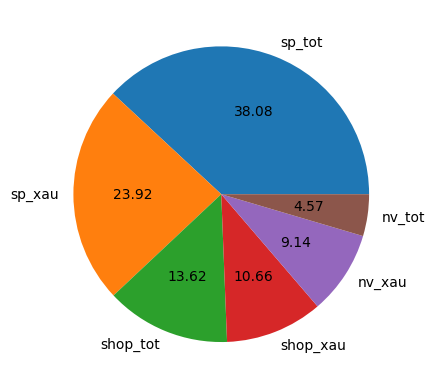

In [10]:
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts.to_cupy().get(), labels=sentiment_counts.to_pandas().index, autopct='%0.2f')

## 6.2. Distribution of num character for each sentiment

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

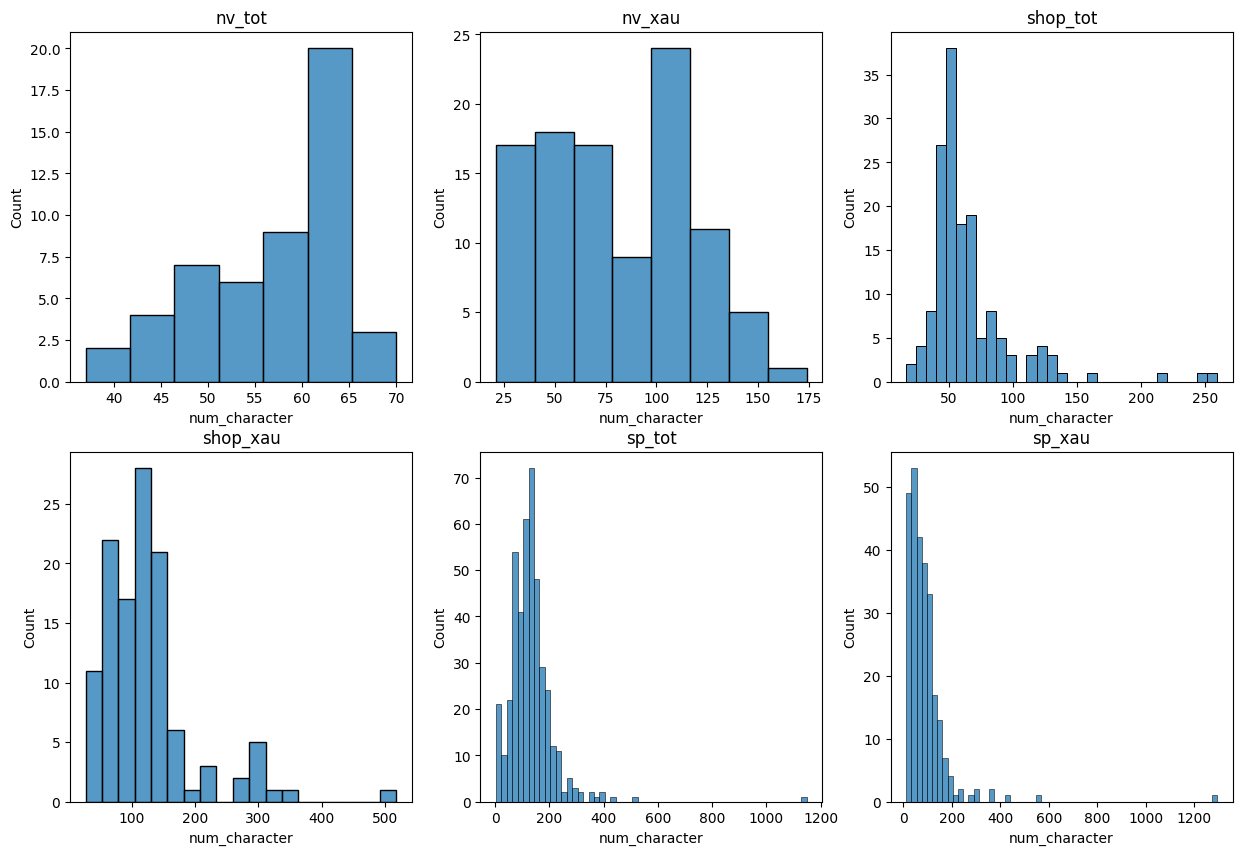

In [11]:
plt.figure(figsize=(15, 10))
df_pd = df.to_pandas()
for i in range(len(CLASS_NAMES)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df_pd[df_pd['Sentiment']==CLASS_NAMES[i]], x="num_character")
    plt.title(CLASS_NAMES[i])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Figure size 1500x500 with 0 Axes>

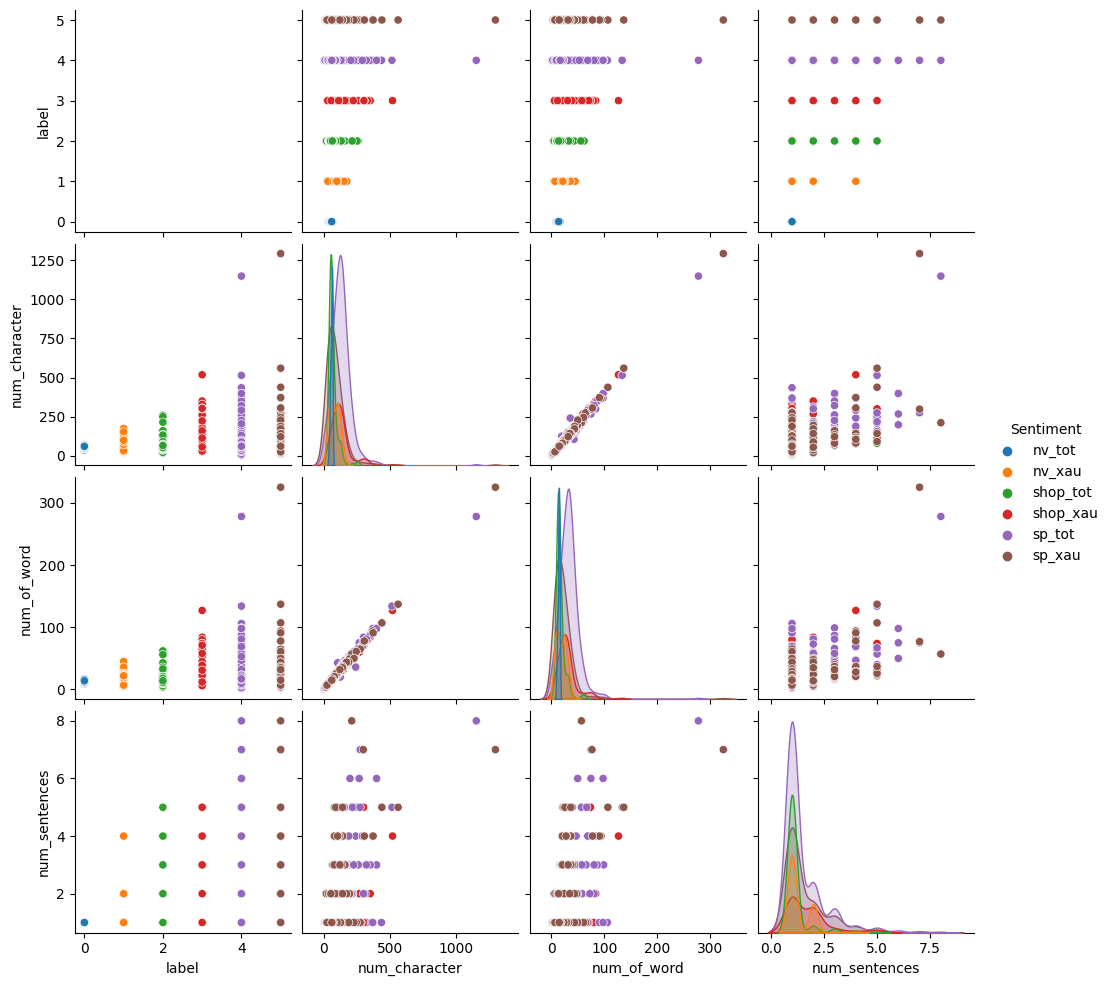

In [12]:
plt.figure(figsize=[15,5])
sns.pairplot(df.to_pandas(), hue='Sentiment')

# 7. Tokenizer

In [13]:

model = load_transformer_model()
model.to("cuda")

docs = [underthesea.word_tokenize(doc.lower()) for doc in df['Review'].to_pandas()]

sentences = []
for sent in docs:
    k = []
    for w in sent:
        k.append(w.replace(" ", "_"))
    sentences.append(" ".join(k))
    
embeddings = model.encode(sentences,batch_size=31, show_progress_bar=True, device="cuda")



False


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

# 8 Splitting dataset

In [14]:
train_texts, val_texts, train_labels, val_labels = train_test_split(embeddings, df['label'], test_size=0.3,
                                                                      random_state=0)

In [15]:
print("Initial GPU Usage")
gpu_usage()    

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 46% |  7% |
|  1 |  0% |  0% |


# 9. Classification sentiment model

## 9.1. Build model

In [16]:
import os.path
print(os.path.isfile('model_svc.model'))
if not os.path.isfile('model_svc.model'):
    param_grid_svc = {
        'C': [0.1, 1, 10],
        'max_iter': [1000],
        'probability': [True]
        }

    pipe_svc = Pipeline([('SVC', GridSearchCV(SVC(), param_grid_svc, cv=3, refit=True, scoring='accuracy'))])

    pipe_svc

False


In [17]:
if not os.path.isfile('model_rf.model'):
    param_grid_rf = { 
        'n_estimators': [200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6],
        'criterion' :['gini', 'entropy']
    }

    pipe_rf = Pipeline([('RF',GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, refit=True, scoring='accuracy'))])

    pipe_rf

In [18]:
if not os.path.isfile('model_lgr.model'):
    param_grid_lgr={"C":np.logspace(-3,3), "penalty":["l1","l2"]}

    pipe_lgr = Pipeline([('LGR', GridSearchCV(LogisticRegression(), param_grid_lgr, cv=3, refit=True, scoring='accuracy'))])

    pipe_lgr

In [19]:
if not os.path.isfile('model_lnsvc.model'):
    param_grid_lnsvc = {
        'C': [0.1, 1, 10],
        'max_iter': [1000],
        }

    pipe_lnSVC = Pipeline([('LNSVC', GridSearchCV(LinearSVC(), param_grid_lnsvc, cv=3, refit=True, scoring='accuracy'))])

    pipe_lnSVC

In [20]:
if not os.path.isfile('model_knn.model'):
    k_range = list(range(1, 10))
    param_grid_knn = dict(n_neighbors=k_range)

    pipe_knn = Pipeline([('KNN', GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, refit=True, scoring='accuracy'))])

    pipe_knn

In [21]:
# param_grid_xgb = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

# pipe_xgboost = Pipeline([('XGB', GridSearchCV(XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1), param_grid_xgb, cv=3, refit=True, scoring='accuracy'))])

# pipe_xgboost

In [22]:
pipelines = []

print(os.path.isfile('model_svc.model'))
if not os.path.isfile('model_svc.model'):
    pipelines.append(("SVC", pipe_svc))
else:
    with open('model_svc.model', 'rb') as f:
        pipelines.append(("SVC", pickle.load(f)))
        
if not os.path.isfile('model_rf.model'):
    pipelines.append(("RF", pipe_rf))
else:
    with open('model_rf.model', 'rb') as f:
        pipelines.append(("RF", pickle.load(f)))
    
if not os.path.isfile('model_lgr.model'):
    pipelines.append(("LGR", pipe_lgr))
else:
    with open('model_lgr.model', 'rb') as f:
        pipelines.append(("LGR", pickle.load(f)))
    
if not os.path.isfile('model_lnsvc.model'):
    pipelines.append(("LNSVC", pipe_lnSVC))
else:
    with open('model_lnsvc.model', 'rb') as f:
        pipelines.append(("LNSVC", pickle.load(f)))
    
if not os.path.isfile('model_knn.model'):
    pipelines.append(("KNN", pipe_knn))
else:
    with open('model_knn.model', 'rb') as f:
        pipelines.append(("KNN", pickle.load(f)))
    
    
# pipelines.append(("XGB", pipe_xgboost))

grid_search_list = []

for pipe ,model in pipelines:
#     kfold = KFold(n_splits=10, random_state=42)
    grid_search_list.append(model.fit(train_texts, train_labels.to_cupy().get()))
    
print(grid_search_list)

False


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

[W] [14:36:08.756721] QWL-QN line search failed (code 3); stopping at the last valid step
[W] [14:36:11.093744] QWL-QN line search failed (code 3); stopping at the last valid step
[W] [14:36:30.370291] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:33.911151] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:34.560115] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:35.708015] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:36.036699] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:40.335512] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [14:36:45.991108] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[I] [14:36:48.366972] Unused keyword parameter: n_jobs during cuML estimator initialization


In [23]:
# clf2 = SVC(probability=True, max_iter=10).fit(train_texts, train_labels)
# clf_rf = RandomForestClassifier().fit(train_texts, train_labels.to_cupy().get())
# clf_lgr = LogisticRegression().fit(train_texts, train_labels)
# lnSVC = LinearSVC()
# clf_lnSVC = CalibratedClassifierCV(lnSVC).fit(train_texts, train_labels.to_cupy().get())
# clf_knn = KNeighborsClassifier().fit(train_texts, train_labels)

In [24]:
tokenized_docs = train_texts[:SIZE_DEMO].astype('U')
tokenized_docs_val = val_texts[:SIZE_DEMO].astype('U')
# tokenized_docs_test = test_texts[:SIZE_DEMO].astype('U')
#
# tfidf = TfidfVectorizer(analyzer="word", tokenizer=identity_tokenizer, token_pattern=None, lowercase=False)
# tfidf = TfidfVectorizer(analyzer="word", tokenizer=underthesea.word_tokenize, token_pattern=None, lowercase=False)
# print(tokenized_docs[:100])
# X_train = tfidf.fit_transform(tokenized_docs)
# print(X_train)
# X_train.shape
# y_train = train_labels[:SIZE_DEMO]
# X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2,
#                                                                                 random_state=0)
# print(sentences)

# clf = LinearSVC().fit(embeddings, y_train)


# clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
# clf = MultinomialNB().fit(X_train, y_train)
# clf = RandomForestClassifier().fit(X_train, y_train)


# def val_process(tfidf, clf):
#     X_val = tfidf.transform(tokenized_docs_val)
#     val_predictions = clf.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))

#     # docs_new = ['God is love', 'OpenGL on the GPU is fast']
#     # X_new_tfidf = tfidf.transform(docs_new)

#     # y_pred = clf.predict(X_new_tfidf)

#     # for doc, category in zip(docs_new, y_pred):
#     #     print('%r => %s' % (doc, category))

#     # X_new_tfidf = tfidf.transform(test_texts)

#     # predicted = clf.predict(X_new_tfidf)

#     # np.mean(predicted == test_labels)

#     param_grid = {
#         'C': [0.1, 1, 10, 100, 1000],
#         # 'max_iter': [1000, 5000, 10000],
#     }

#     # tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

#     # parameters = {
#     #     'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
#     # }

#     # parameters = {
#     #     'max_depth':[3,5,10,None],
#     #               'n_estimators':[10,100,200],
#     #               'max_features':[1,3,5,7],
#     #               'min_samples_leaf':[1,2,3],
#     #               'min_samples_split':[1,2,3]
#     # }

#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(LinearSVC(), param_grid, cv=3, refit=True, scoring='accuracy')

#     # grid_search = GridSearchCV(tree.DecisionTreeClassifier(), tree_param, cv=3, refit = True, scoring='accuracy')

#     # grid_search = GridSearchCV(MultinomialNB(), parameters, cv=3, refit = True, scoring='accuracy')

#     # grid_search = GridSearchCV(RandomForestClassifier(), parameters, cv=3, refit = True, scoring='accuracy')

#     # Fit the grid search
#     grid_search.fit(X_train, train_labels[:SIZE_DEMO])

#     # Best parameters
#     best_params = grid_search.best_params_
#     print(f"Best Parameters: {best_params}")

#     # Evaluate best model on validation set
#     best_model = grid_search.best_estimator_
#     val_predictions = best_model.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy with Best Model: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))


## 9.2. Best params for model

### 9.2.1. SVC

In [25]:
best_params = grid_search_list[0]['SVC'].best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 10, 'max_iter': 1000, 'probability': True}


### 9.2.2. Random Forest

In [26]:
best_params = grid_search_list[1]['RF'].best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}


### 9.2.3. Logistic Regression

In [27]:
best_params = grid_search_list[2]['LGR'].best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 0.868511373751352, 'penalty': 'l2'}


### 9.2.4. Linear SVC

In [28]:
best_params = grid_search_list[3]['LNSVC'].best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 0.1, 'max_iter': 1000}


### 9.2.5. KNN

In [29]:
best_params = grid_search_list[4]['KNN'].best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'n_neighbors': 3}


## 9.3. Best estimator

### 9.3.1. SVC

In [30]:
clf2 = grid_search_list[0]['SVC'].best_estimator_

### 9.3.2. Random Forest

In [31]:
clf_rf = grid_search_list[1]['RF'].best_estimator_

### 9.3.3. Logistic Regression

In [32]:
clf_lgr = grid_search_list[2]['LGR'].best_estimator_

### 9.3.4. Linear SVC

In [33]:
clf_lnSVC = CalibratedClassifierCV(grid_search_list[3]['LNSVC'].best_estimator_).fit(train_texts, train_labels.to_cupy().get())

### 9.3.5 KNN

In [34]:
clf_knn = grid_search_list[4]['KNN'].best_estimator_

# 10. Accuracy and F1 score

In [35]:


# def val_process2(model, clf):
#     nv_tot_val = val_texts[val_labels[val_labels == "nv_tot"].index]
#     nv_xau_val = val_texts[val_labels[val_labels == "nv_xau"].index]
#     shop_tot_val = val_texts[val_labels[val_labels == "shop_tot"].index]
#     shop_xau_val = val_texts[val_labels[val_labels == "shop_xau"].index]
#     sp_tot_val = val_texts[val_labels[val_labels == "sp_tot"].index]
#     sp_xau_val = val_texts[val_labels[val_labels == "sp_xau"].index]
#     nv_tot_val = nv_tot_val[:2000]
#     nv_tot_val = pd.concat([nv_tot_val, nv_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_xau_val[:2000]])
#     nv_tot_val= pd.concat([nv_tot_val, sp_tot_val[:2000]])
#     nv_tot_val= pd.concat([nv_tot_val, sp_xau_val[:2000]])
#     docs_val = [underthesea.word_tokenize(sent.lower()) for sent in nv_tot_val]
#     sentences_val = []
#     for sent in docs_val:
#         k = []
#         for w in sent:
#             k.append(w.replace(" ", "_"))
#         sentences_val.append(" ".join(k))
#     # print(len(sentences))
#     embeddings_val = model.encode(sentences_val, show_progress_bar=True)
#     # X_val = tfidf.transform(tokenized_docs_val)
#     val_predictions = clf.predict(embeddings_val)
#     # val_predictions = clf.predict(X_val)
#     val_accuracy = accuracy_score(val_labels[:SIZE_DEMO], val_predictions)
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(classification_report(val_labels[:SIZE_DEMO], val_predictions))


# # val_process(tfidf, clf)

# # val_process2(model, clf)


# def train_demo(df_train, tfidf, clf):
#     for index, row in df_train.iterrows():
#         X_val = tfidf.transform([row['Review']])
#         row['Sentiment'] = str(clf.predict(X_val)).strip('[]\'')
#         print(f"{row['Review']}=>{row['Sentiment']}")


def draw_graph(df):
    df_tmp = df
    df_tmp.loc[df_tmp['Sentiment'] == 'positive', 'Sentiment_num'] = 1
    df_tmp.loc[df_tmp['Sentiment'] == 'negative', 'Sentiment_num'] = 0
    df_tmp.loc[df_tmp['Sentiment'] == 'neutral', 'Sentiment_num'] = 2
    # df_tmp2 = pd.DataFrame({
    #     'Sentiment': df_tmp['Sentiment'],
    #     'Sentiment_num': df_tmp['Sentiment_num']
    # })
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='Sentiment', y='Sentiment_num', data=df_tmp)
    plt.show()


def df_transformer(embeddings):
    # nv_tot = df.loc[df['Sentiment'] == "nv_tot"]
    # nv_xau = df.loc[df['Sentiment'] == "nv_xau"]
    # shop_tot = df.loc[df['Sentiment'] == "shop_tot"]
    # shop_xau = df.loc[df['Sentiment'] == "shop_xau"]
    # sp_tot = df.loc[df['Sentiment'] == "sp_tot"]
    # sp_xau = df.loc[df['Sentiment'] == "sp_xau"]
    # nv_tot = nv_tot[:2000]
    # nv_tot = pd.concat([nv_tot, nv_xau.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, shop_tot.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, shop_xau.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, sp_tot.loc[:2000]])
    # nv_tot = pd.concat([nv_tot, sp_xau.loc[:2000]])
    # docs = [underthesea.word_tokenize(sent.lower()) for sent in nv_tot['Review']]
    # model = load_transformer_model()
    # sentences = []
    # for sent in docs:
    #     k = []
    #     for w in sent:
    #         k.append(w.replace(" ", "_"))
    #     sentences.append(" ".join(k))
    # # print(sentences)
    # embeddings = model.encode(sentences, show_progress_bar=True)
    tsne = TSNE(n_components=3, perplexity=2, random_state=42)
    X_tsne = tsne.fit_transform(embeddings)
    ax = plt.figure(figsize=(12,12)).add_subplot(111, projection ="3d")
    # pallete = sns.color_palette('hsv', 3)
    # sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2], hue=pos['Sentiment'], palette=pallete)
    cmap = ListedColormap(sns.color_palette("hsv", 5))
    # groups = pd.DataFrame(X_tsne, columns=['x', 'y', 'z']).assign(category=nv_tot['Sentiment'])
    print(f'{X_tsne.shape}')
    # cdict = {'positive': 'red', 'negative': 'blue', 'neutral': 'green'}
    # for sen in pos['Sentiment'].unique():
    sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=X_tsne[:, 0], cmap=cmap, alpha=0.8)


    plt.title("truc quan hoa du lieu tuyen tinh")
    # plt.legend(*sc.legend_elements())
    # legend1 = ax.legend(*[sc.legend_elements()[0], pos['Sentiment']],
    #                     title="Legend")
    # ax.add_artist(legend1)
    # ax.legend()
    plt.show()


# def df_tfidf(df):
#     pos = df.loc[df['Sentiment'] == "positive"]
#     neg = df.loc[df['Sentiment'] == "negative"]
#     neu = df.loc[df['Sentiment'] == "neutral"]
#     pos = pd.concat([pos, pos.loc[:200]])
#     pos = pd.concat([pos, neg.loc[:200]])
#     pos = pd.concat([pos, neu.loc[:200]])
#     # docs = [underthesea.word_tokenize(sent.lower()) for sent in pos['Review']]
#     # model = None
#     # if not load_transformer_model():
#     #     model = SentenceTransformer('model')
#     # sentences = []
#     # for sent in docs:
#     #     k = []
#     #     for w in sent:
#     #         k.append(w.replace(" ", "_"))
#     #     sentences.append(" ".join(k))
#     # print(sentences)
#     # embeddings = model.encode(sentences, show_progress_bar=True)
#     X_tfidf = tfidf.fit_transform(pos['Review'])
#     pca = PCA(n_components=2).fit_transform(X_tfidf.todense())
#     # X_tsne = pca.transform(X_tfidf.toarray())
#     plt.figure(figsize=(6,4))
#     pallete = sns.color_palette('hsv', 3)
#     sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=pos['Sentiment'], palette=pallete)
#
#     plt.title("truc quan hoa du lieu tuyen tinh")
#     plt.show()


def SVC_model(clf2, X_train, y_train2, model, X_val, y_val):
#     clf2 = SVC(probability=True, max_iter=10).fit(embeddings2, y_train2)
    scores = cross_val_score(clf2, X_train, y_train2.to_cupy().get(), cv=10)
    print(scores)
#     nv_tot_val = val_texts[val_labels[val_labels == "nv_tot"].index]
#     nv_xau_val = val_texts[val_labels[val_labels == "nv_xau"].index]
#     shop_tot_val = val_texts[val_labels[val_labels == "shop_tot"].index]
#     shop_xau_val = val_texts[val_labels[val_labels == "shop_xau"].index]
#     sp_tot_val = val_texts[val_labels[val_labels == "sp_tot"].index]
#     sp_xau_val = val_texts[val_labels[val_labels == "sp_xau"].index]
#     nv_tot_val = nv_tot_val[:2000]
#     nv_tot_val = pd.concat([nv_tot_val, nv_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, shop_xau_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, sp_tot_val[:2000]])
#     nv_tot_val = pd.concat([nv_tot_val, sp_xau_val[:2000]])
#     docs_val = remove_stop_words(nv_tot_val, stopwords)
#     docs_val = [underthesea.word_tokenize(sent.lower()) for sent in val_texts.to_pandas()]
#     sentences_val = []
#     for sent in docs_val:
#         k = []
#         for w in sent:
#             k.append(w.replace(" ", "_"))
#         sentences_val.append(" ".join(k))
#     # print(len(sentences))
#     embeddings_val = model.encode(sentences_val, batch_size=31, show_progress_bar=True)
    # X_val = tfidf.transform(tokenized_docs_val)
    val_predictions = clf2.predict(X_val)
    # val_predictions = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val.to_cupy().get(), val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(classification_report(y_val.to_cupy().get(), val_predictions))


# draw_graph(df)


# df_tfidf(df)

# df_transformer(embeddings)

print("\n SVC model \n")
SVC_model(clf2, train_texts, train_labels, model, val_texts, val_labels)
print("\n Random forest model \n")
SVC_model(clf_rf, train_texts, train_labels, model, val_texts, val_labels)
print("\n Logistic Regression model \n")
SVC_model(clf_lgr, train_texts, train_labels, model, val_texts, val_labels)
print("\n Linear SVC model \n")
SVC_model(clf_lnSVC, train_texts, train_labels, model, val_texts, val_labels)
print("\n KNN model \n")
SVC_model(clf_knn, train_texts, train_labels, model, val_texts, val_labels)


 SVC model 

[0.92405063 0.83333331 0.94871795 0.87179488 0.85897434 0.92307693
 0.82051283 0.88461536 0.92307693 0.91025639]
Validation Accuracy: 0.8925
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.95      0.91      0.93        22
           2       0.82      0.88      0.85        42
           3       0.88      0.73      0.80        30
           4       0.92      0.91      0.92       140
           5       0.88      0.90      0.89        89

    accuracy                           0.89       335
   macro avg       0.89      0.89      0.89       335
weighted avg       0.89      0.89      0.89       335


 Random forest model 

[0.83544304 0.75641026 0.79487179 0.71794872 0.78205128 0.80769231
 0.75641026 0.80769231 0.85897436 0.80769231]
Validation Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.78     

# 11. ROC curve


 SVC model 


 Random forest model 


 Logistic Regression model 


 Linear SVC model 


 KNN model 



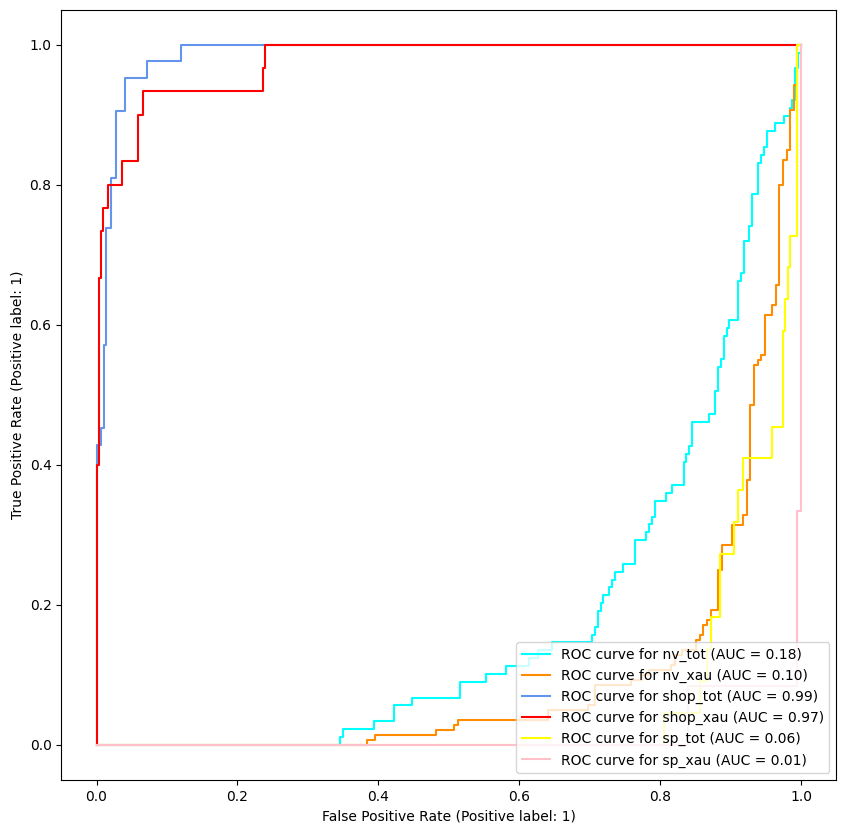

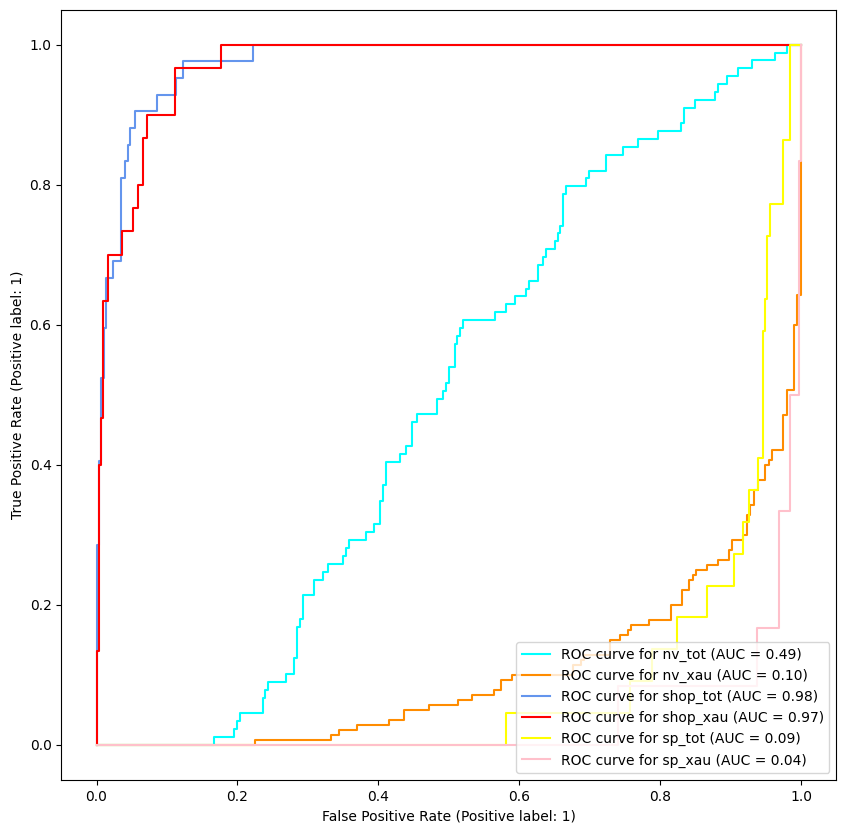

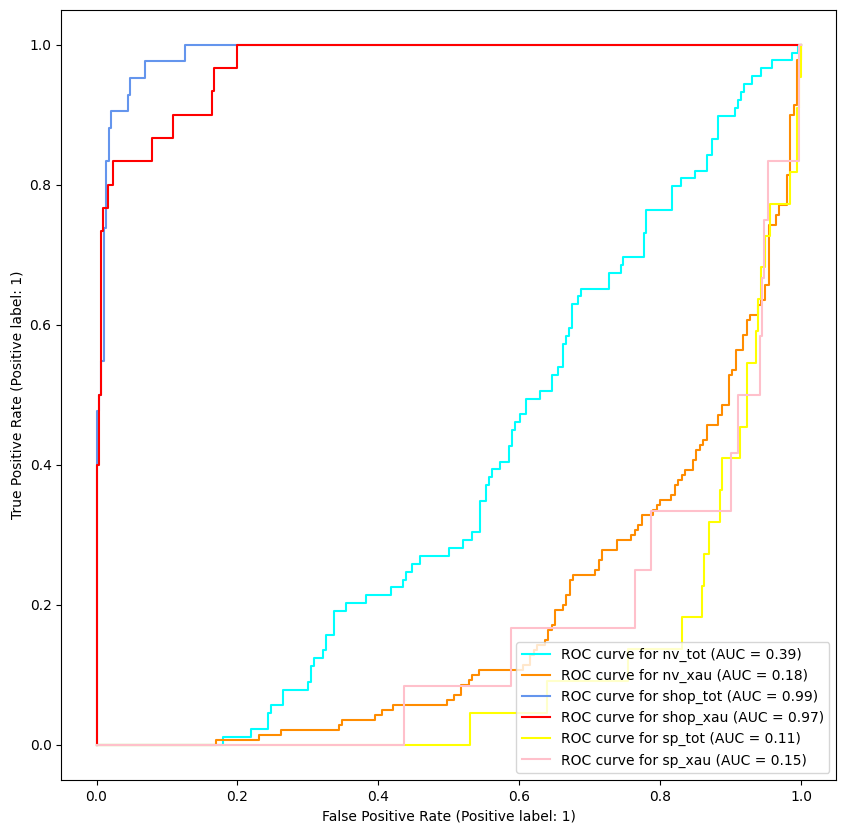

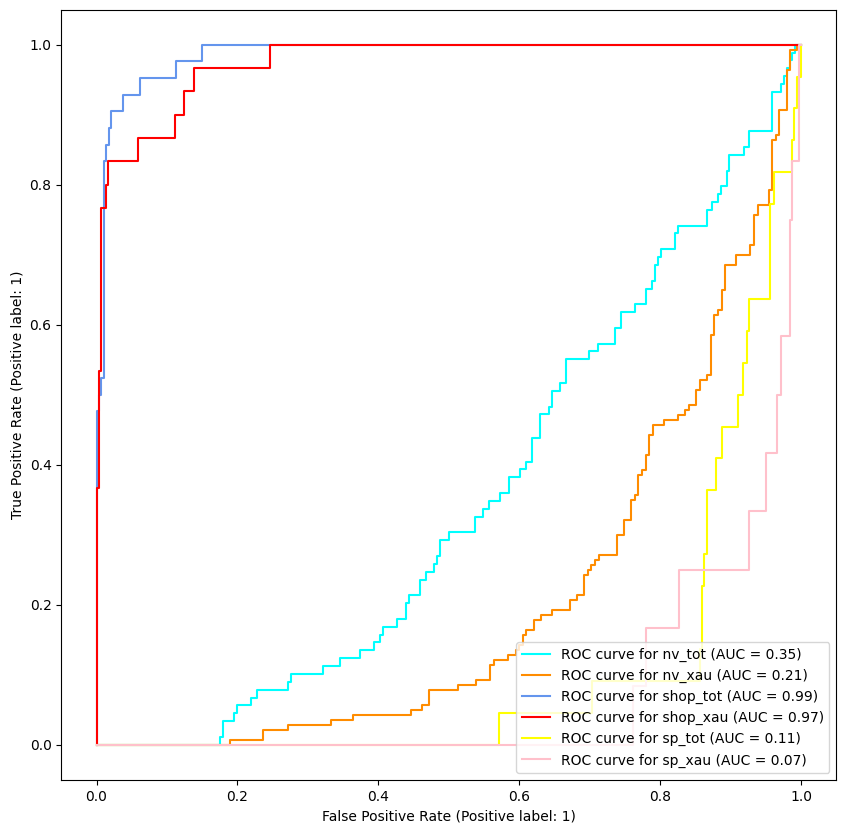

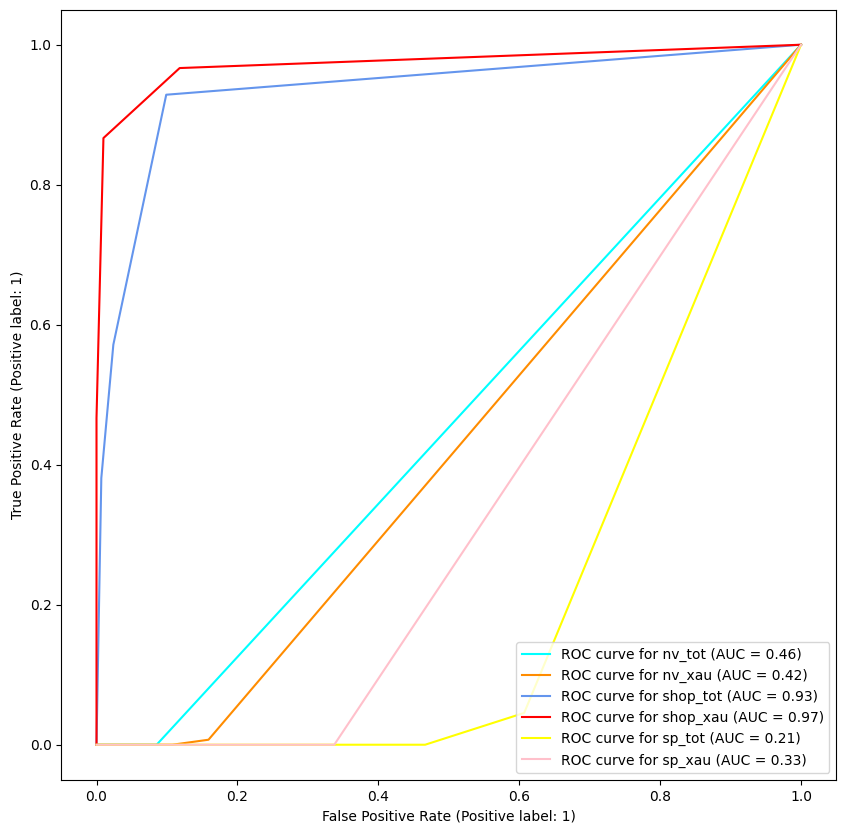

In [36]:
def ROC_curve_SVC(svc, X_test, y_test, class_names):
    # ax = plt.gca()
    # rfc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax, alpha=0.8)
    # svc_disp.plot(ax=ax, alpha=0.8)
    # plt.show()
    # predicted = svc.predict(X_test)
    predicted_proba = svc.predict_proba(X_test)
    # roc_auc = roc_auc_score(y_test, predicted_proba, multi_class='ovr')
    # print(roc_auc)
    target = label_binarize(y_test.to_cupy().get(),
                        classes=pd.unique(y_test.to_cupy().get()))
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "yellow", "pink"])
    for class_id, color in zip(range(len(pd.unique(df['label'].to_cupy().get()))), colors):
        RocCurveDisplay.from_predictions(
            target[:, class_id],
            predicted_proba [:, class_id],
            name=f"ROC curve for {class_names[class_id]}",
            color=color,
            ax=ax,
        )
    
print("\n SVC model \n")
ROC_curve_SVC(clf2, val_texts, val_labels, CLASS_NAMES)
print("\n Random forest model \n")
ROC_curve_SVC(clf_rf, val_texts, val_labels, CLASS_NAMES)
print("\n Logistic Regression model \n")
ROC_curve_SVC(clf_lgr, val_texts, val_labels, CLASS_NAMES)
print("\n Linear SVC model \n")
ROC_curve_SVC(clf_lnSVC, val_texts, val_labels, CLASS_NAMES)
print("\n KNN model \n")
ROC_curve_SVC(clf_knn, val_texts, val_labels, CLASS_NAMES)

# 12. Confusion matrix


 SVC model 

Confusion matrix, without normalization
[[ 12   0   0   0   0   0]
 [  0  20   0   2   0   0]
 [  2   1  37   0   2   0]
 [  0   0   0  22   1   7]
 [  0   0   7   1 128   4]
 [  0   0   1   0   8  80]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.90909091 0.         0.09090909 0.         0.        ]
 [0.04761905 0.02380952 0.88095238 0.         0.04761905 0.        ]
 [0.         0.         0.         0.73333333 0.03333333 0.23333333]
 [0.         0.         0.05       0.00714286 0.91428571 0.02857143]
 [0.         0.         0.01123596 0.         0.08988764 0.8988764 ]]


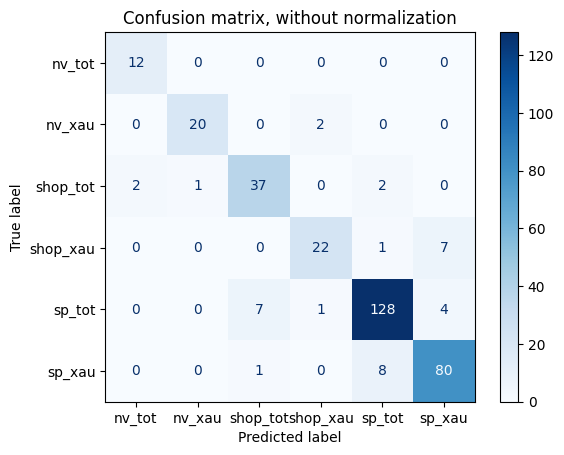

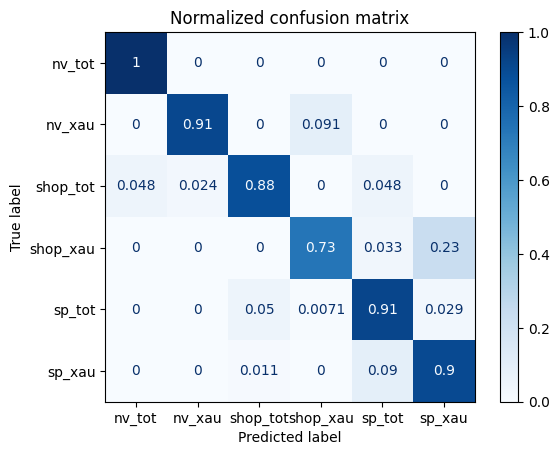


 Random Forest model 

Confusion matrix, without normalization
[[ 10   1   0   0   1   0]
 [  0  18   1   1   1   1]
 [  2   2  21   0  15   2]
 [  0   2   0  13   6   9]
 [  0   0   1   0 139   0]
 [  0   0   1   0  21  67]]
Normalized confusion matrix
[[0.83333333 0.08333333 0.         0.         0.08333333 0.        ]
 [0.         0.81818182 0.04545455 0.04545455 0.04545455 0.04545455]
 [0.04761905 0.04761905 0.5        0.         0.35714286 0.04761905]
 [0.         0.06666667 0.         0.43333333 0.2        0.3       ]
 [0.         0.         0.00714286 0.         0.99285714 0.        ]
 [0.         0.         0.01123596 0.         0.23595506 0.75280899]]


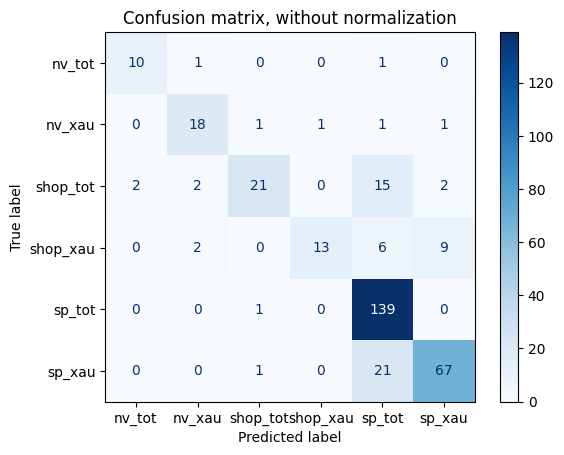

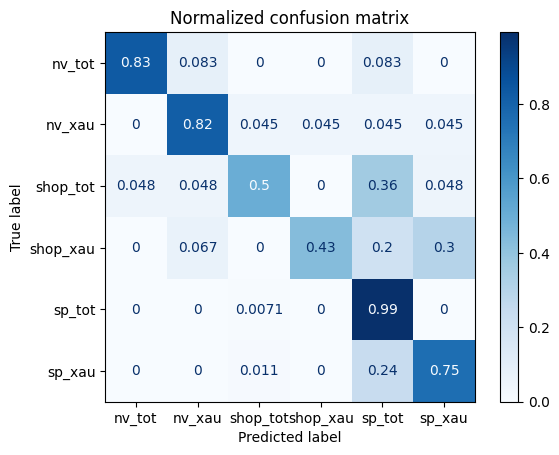


 Logistic Regression model 

Confusion matrix, without normalization
[[ 12   0   0   0   0   0]
 [  0  20   0   2   0   0]
 [  1   1  36   0   3   1]
 [  0   0   0  21   1   8]
 [  0   0   5   1 128   6]
 [  0   0   1   0   9  79]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.90909091 0.         0.09090909 0.         0.        ]
 [0.02380952 0.02380952 0.85714286 0.         0.07142857 0.02380952]
 [0.         0.         0.         0.7        0.03333333 0.26666667]
 [0.         0.         0.03571429 0.00714286 0.91428571 0.04285714]
 [0.         0.         0.01123596 0.         0.1011236  0.88764045]]


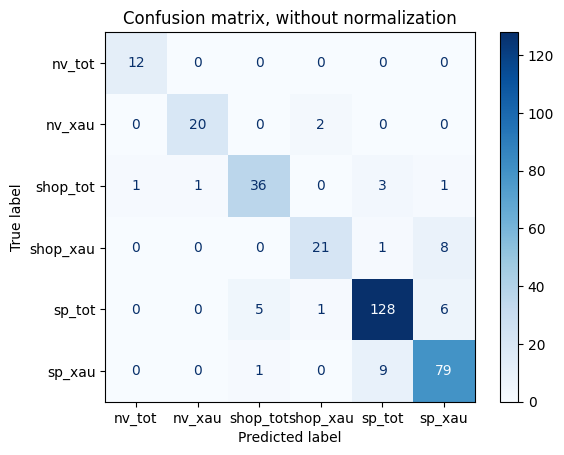

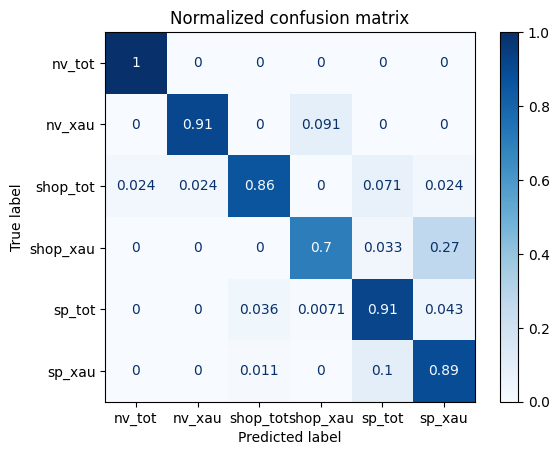


 Linear SVC model 

Confusion matrix, without normalization
[[ 12   0   0   0   0   0]
 [  0  20   1   1   0   0]
 [  2   0  36   0   3   1]
 [  0   0   0  22   1   7]
 [  0   0   4   1 129   6]
 [  0   0   1   0  10  78]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.90909091 0.04545455 0.04545455 0.         0.        ]
 [0.04761905 0.         0.85714286 0.         0.07142857 0.02380952]
 [0.         0.         0.         0.73333333 0.03333333 0.23333333]
 [0.         0.         0.02857143 0.00714286 0.92142857 0.04285714]
 [0.         0.         0.01123596 0.         0.11235955 0.87640449]]


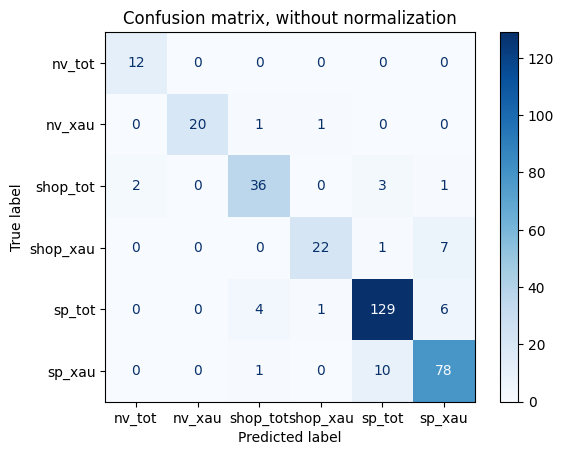

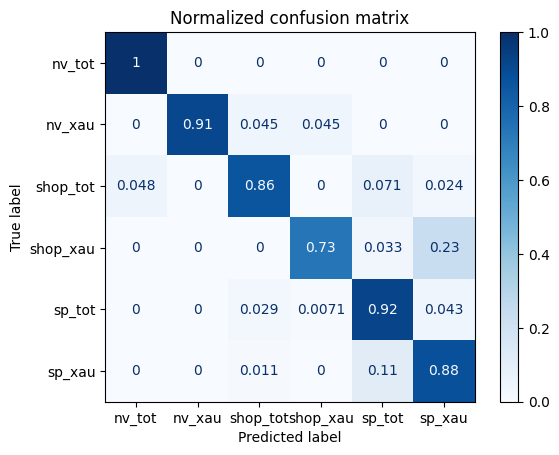


 KNN model 

Confusion matrix, without normalization
[[ 12   0   0   0   0   0]
 [  1  20   1   0   0   0]
 [  6   4  27   0   5   0]
 [  0   1   1  27   1   0]
 [  0   0   9   2 127   2]
 [  0   1   1   7  13  67]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.        ]
 [0.04545455 0.90909091 0.04545455 0.         0.         0.        ]
 [0.14285714 0.0952381  0.64285714 0.         0.11904762 0.        ]
 [0.         0.03333333 0.03333333 0.9        0.03333333 0.        ]
 [0.         0.         0.06428571 0.01428571 0.90714286 0.01428571]
 [0.         0.01123596 0.01123596 0.07865169 0.14606742 0.75280899]]


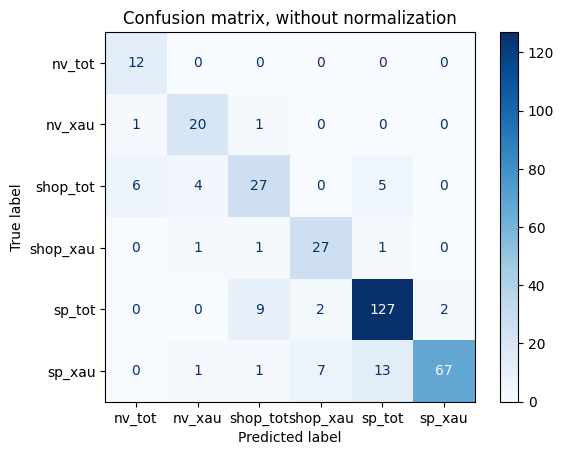

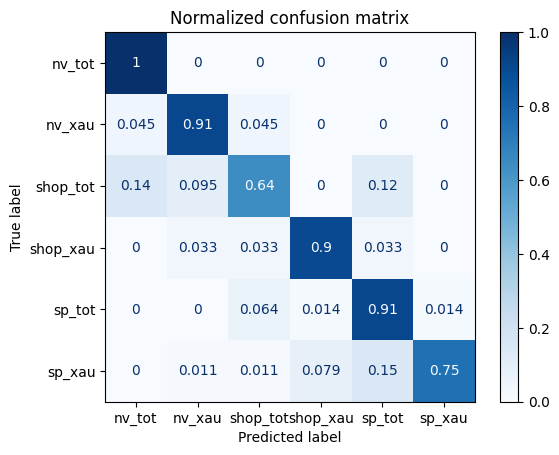

In [37]:
def confusion_matrix_svc(clf2, X_test, y_test, class_names):
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf2,
            X_test,
            y_test.to_cupy().get(),
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
    
        print(title)
        print(disp.confusion_matrix)
    
    plt.show()

print("\n SVC model \n")
confusion_matrix_svc(clf2, val_texts, val_labels, CLASS_NAMES)
print("\n Random Forest model \n")
confusion_matrix_svc(clf_rf, val_texts, val_labels, CLASS_NAMES)
print("\n Logistic Regression model \n")
confusion_matrix_svc(clf_lgr, val_texts, val_labels, CLASS_NAMES)
print("\n Linear SVC model \n")
confusion_matrix_svc(clf_lnSVC, val_texts, val_labels, CLASS_NAMES)
print("\n KNN model \n")
confusion_matrix_svc(clf_knn, val_texts, val_labels, CLASS_NAMES)

# 13. Save model

In [38]:
with open('model_svc.model','wb') as f:
    pickle.dump(grid_search_list[0],f)
    
with open('model_rf.model','wb') as f:
    pickle.dump(grid_search_list[1],f)
    
with open('model_lgr.model','wb') as f:
    pickle.dump(grid_search_list[2],f)
    
with open('model_lnsvc.model','wb') as f:
    pickle.dump(grid_search_list[3],f)
    
with open('model_knn.model','wb') as f:
    pickle.dump(grid_search_list[4],f)

In [39]:
# os.remove("/kaggle/working/model_svc.model")
# os.remove("/kaggle/working/model_rf.model")
# os.remove("/kaggle/working/model_lgr.model")
# os.remove("/kaggle/working/model_lnsvc.model")
# os.remove("/kaggle/working/model_knn.model")